## **Homework 6**

Zhou Fang, Sophy Huang, Julian Zhao

### Import Packages and Data

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from pandas import DataFrame
import time
import torch
import transformers as ppb
import warnings
from ipywidgets import IntProgress
warnings.filterwarnings('ignore')

In [3]:
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import re

[nltk_data] Downloading package stopwords to /Users/sophy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
rt = pd.read_csv("rt_reviews.csv")

In [5]:
rt

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
...,...,...,...,...,...,...,...,...
1130012,m/zulu_dawn,Chuck O'Leary,False,Fantastica Daily,Rotten,2/5,2005-11-02,NaN
1130013,m/zulu_dawn,Ken Hanke,False,"Mountain Xpress (Asheville, NC)",Fresh,3.5/5,2007-03-07,"Seen today, it's not only a startling indictme..."
1130014,m/zulu_dawn,Dennis Schwartz,False,Dennis Schwartz Movie Reviews,Fresh,B+,2010-09-16,A rousing visual spectacle that's a prequel of...
1130015,m/zulu_dawn,Christopher Lloyd,False,Sarasota Herald-Tribune,Rotten,3.5/5,2011-02-28,"A simple two-act story: Prelude to war, and th..."


### Initial Analysis

In [ ]:
rt1 = 

### Classification

***Initial Cleaning & Create review-term matrix***

In [12]:
#Get rid of NA content (reviews)
rt = rt[rt['review_content'].notna()]

In [50]:
#Only review_content columns and top_critic (conversion to 0 and 1)
rt_critic = rt[['review_content','top_critic']]
rt_critic.loc[(rt_critic.top_critic == False),'top_critic']=0
rt_critic.loc[(rt_critic.top_critic == True),'top_critic']=1
rt_critic

,review_content,top_critic
0,A fantasy adventure that fuses Greek mythology...,0
1,"Uma Thurman as Medusa, the gorgon with a coiff...",0
2,With a top-notch cast and dazzling special eff...,0
3,Whether audiences will get behind The Lightnin...,0
4,What's really lacking in The Lightning Thief i...,1
...,...,...
1130008,A rousing reconstruction of the 1879 Battle of...,0
1130013,"Seen today, it's not only a startling indictme...",0
1130014,A rousing visual spectacle that's a prequel of...,0
1130015,"A simple two-act story: Prelude to war, and th...",0


In [60]:
# Copy rt_critic to rt_critic_new
rt_critic_new = pd.DataFrame.copy(rt_critic.sample(5000))

In [61]:
# Text normalization

#Tokenization of text
tokenizer=ToktokTokenizer()

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
custom_stopword = ['[',']','[]']
stopword_list.append(custom_stopword)

#set stopwords to english
stop=set(stopwords.words('english'))

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on review column
rt_critic_new['review_content']=rt_critic_new['review_content'].apply(remove_stopwords)

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
rt_critic_new['review_content']=rt_critic_new['review_content'].apply(remove_special_characters)

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
rt_critic_new['review_content']=rt_critic_new['review_content'].apply(remove_between_square_brackets)

In [62]:
vectorizer = CountVectorizer()
dtm = vectorizer.fit_transform(rt_critic_new['review_content'])

In [106]:
vocab = vectorizer.get_feature_names()
matrix = dtm.toarray()
df_vec = DataFrame(matrix, columns=vocab)

In [107]:
rt_critic_new['top_critic'].value_counts()

0    3746
1    1254
Name: top_critic, dtype: int64

In [108]:
rt_critic_new['review_id'] = range(5000)

In [109]:
# this is our sample of "metadata"
rt_critic_new=rt_critic_new.reset_index()
del rt_critic_new['index']
rt_critic_new

,review_content,top_critic,review_id
0,film threads enough thoughtful commentary whir...,0,0
1,nuanced geopolitical parable repurposed generi...,0,1
2,Aniston heavy lifting carrying Mother Day st...,0,2
3,Belying title Like Crazy film ferocity love ...,1,3
4,SPINAL TAP millennials knowing often hilariou...,0,4
...,...,...,...
4995,film troubling awards season Unless handing ...,0,4995
4996,Hayao Miyazaki game film weaker art animation ...,0,4996
4997,actionmovie pyrotechnics succeed reinforcing S...,0,4997
4998,chronicle city falling love rock Levitated Ma...,0,4998


In [110]:
# concatenate metadata and review-term dataframe
df_concat = pd.concat([rt_critic_new, df_vec], axis = 1)
df_concat.head()

,review_content,top_critic,review_id,10,100,1000,100million,100yearold,101,10yearolds,...,zombeavers,zombie,zombies,zombpocalypse,zone,zoolander,zooms,zulay,zwick,zzz
0,film threads enough thoughtful commentary whir...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,nuanced geopolitical parable repurposed generi...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aniston heavy lifting carrying Mother Day st...,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Belying title Like Crazy film ferocity love ...,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SPINAL TAP millennials knowing often hilariou...,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
df_concat

,review_content,top_critic,review_id,10,100,1000,100million,100yearold,101,10yearolds,...,zombeavers,zombie,zombies,zombpocalypse,zone,zoolander,zooms,zulay,zwick,zzz
0,film threads enough thoughtful commentary whir...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,nuanced geopolitical parable repurposed generi...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aniston heavy lifting carrying Mother Day st...,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Belying title Like Crazy film ferocity love ...,1,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SPINAL TAP millennials knowing often hilariou...,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,film troubling awards season Unless handing ...,0,4995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,Hayao Miyazaki game film weaker art animation ...,0,4996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,actionmovie pyrotechnics succeed reinforcing S...,0,4997,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4998,chronicle city falling love rock Levitated Ma...,0,4998,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


***Equalize numbers of top critics and critics***

In [112]:
# select 1000 of each type of critics into the dataset
rt_top = df_concat[df_concat['top_critic'] == 1]
rt_nontop = df_concat[df_concat['top_critic'] == 0]

#For testing (performance) purposes, we only randomly select 1000 rows 
rt_top = rt_top.sample(n=1000)
rt_nontop = rt_nontop.sample(n=1000)
df_final = pd.concat([rt_top,rt_nontop])
df_final = df_final.reset_index()
df_final = df_final.drop(columns="index")
df_final

,review_content,top_critic,review_id,10,100,1000,100million,100yearold,101,10yearolds,...,zombeavers,zombie,zombies,zombpocalypse,zone,zoolander,zooms,zulay,zwick,zzz
0,Writer Jeffrey Caine director Damien Donnell ...,1,2243,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ambiguity effective dramatic tool also result...,1,412,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Everyone sees film favorite moments,1,2209,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Even one gets past movie controversial depict...,1,59,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,necessary share documentary taste headbangin...,1,226,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Even TV show obvious TV style huge closeups...,0,4285,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,Striptease amiable comedy ambitions satire th...,0,1273,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,Cedric Kahn adept building Hitchcockian suspen...,0,3559,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,One great things 33 toorare portrayal South ...,0,105,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


***Match meta and data dataframes with subset of df_final***

In [118]:
meta = df_final[["review_content", "top_critic", "review_id"]]
meta

,review_content,top_critic,review_id
0,Writer Jeffrey Caine director Damien Donnell ...,1,2243
1,Ambiguity effective dramatic tool also result...,1,412
2,Everyone sees film favorite moments,1,2209
3,Even one gets past movie controversial depict...,1,59
4,necessary share documentary taste headbangin...,1,226
...,...,...,...
1995,Even TV show obvious TV style huge closeups...,0,4285
1996,Striptease amiable comedy ambitions satire th...,0,1273
1997,Cedric Kahn adept building Hitchcockian suspen...,0,3559
1998,One great things 33 toorare portrayal South ...,0,105


In [128]:
meta['top_critic'].astype('int')

0       1
1       1
2       1
3       1
4       1
       ..
1995    0
1996    0
1997    0
1998    0
1999    0
Name: top_critic, Length: 2000, dtype: int64

In [129]:
df = df_final.loc[:,'10':]
df

,10,100,1000,100million,100yearold,101,10yearolds,11,11th,12,...,zombeavers,zombie,zombies,zombpocalypse,zone,zoolander,zooms,zulay,zwick,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
df[:].astype('float64')

,10,100,1000,100million,100yearold,101,10yearolds,11,11th,12,...,zombeavers,zombie,zombies,zombpocalypse,zone,zoolander,zooms,zulay,zwick,zzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Run the Classfier***

In [131]:
meta['PROBS'] = ''
meta['PREDICTED'] = ''

In [132]:
model = LogisticRegression(penalty = 'l1', C = 1.0, solver='liblinear')

In [134]:
for this_index in df_final.index.tolist():
    print(this_index) # keep track of where we are in the corpus
    title = meta.loc[meta.index[this_index], 'review_content'] 
    CLASS = meta.loc[meta.index[this_index], 'top_critic']
    print(title, CLASS) 
    
    train_index_list = [index_ for index_ in df.index.tolist() if index_ != this_index] # exclude the title to be predicted
    X = df.loc[train_index_list] # the model trains on all the data except the excluded title row
    y = meta.loc[train_index_list, 'top_critic'] # the y row tells the model which class each title belongs to
    y = y.astype('int')
    TEST_CASE = df.loc[[this_index]]

    model.fit(X,y) # fit the model
    prediction = model.predict_proba(TEST_CASE) # calculate probability of test case
    predicted = model.predict(TEST_CASE) # calculate predicted class of test case
    meta.at[this_index, 'PREDICTED'] = predicted # add predicted class to metadata
    meta.at[this_index, 'PROBS'] = str(prediction) # add probabilities to metadata
    print('Class is: ' + str(CLASS) + '\n' + 'Prediction is: ' + str(predicted) + ' ' + str(prediction) + '\n')

0
Writer Jeffrey Caine director Damien  Donnell cut vital organ moments hardsell poignancy  1
Class is: 1
Prediction is: [1] [[0.23717683 0.76282317]]

1
Ambiguity effective dramatic tool  also result unsatisfying evasions   afraid case  1
Class is: 1
Prediction is: [1] [[0.39149245 0.60850755]]

2
Everyone sees film favorite moments  1
Class is: 1
Prediction is: [1] [[0.42737048 0.57262952]]

3
Even one gets past movie  controversial depictions  matter secondrate  madefortelevision fare  poor battle choreography  wooden editing cheesy writing  1
Class is: 1
Prediction is: [0] [[0.50221851 0.49778149]]

4
 necessary share documentary  taste headbanging music  indulges exuberant array concert clips  appreciate bemused  articulate interviewees larger wit  1
Class is: 1
Prediction is: [1] [[0.38216424 0.61783576]]

5
Kidman  looking almost anorexic grief sharply critical everyone trying comfort  including husband  good time  1
Class is: 1
Prediction is: [1] [[0.49384842 0.50615158]]

6
Ag

***Results***

In [135]:
meta

,review_content,top_critic,review_id,PROBS,PREDICTED
0,Writer Jeffrey Caine director Damien Donnell ...,1,2243,[[0.23717683 0.76282317]],[1]
1,Ambiguity effective dramatic tool also result...,1,412,[[0.39149245 0.60850755]],[1]
2,Everyone sees film favorite moments,1,2209,[[0.42737048 0.57262952]],[1]
3,Even one gets past movie controversial depict...,1,59,[[0.50221851 0.49778149]],[0]
4,necessary share documentary taste headbangin...,1,226,[[0.38216424 0.61783576]],[1]
...,...,...,...,...,...
1995,Even TV show obvious TV style huge closeups...,0,4285,[[0.55333921 0.44666079]],[0]
1996,Striptease amiable comedy ambitions satire th...,0,1273,[[0.47027023 0.52972977]],[1]
1997,Cedric Kahn adept building Hitchcockian suspen...,0,3559,[[0.54737475 0.45262525]],[0]
1998,One great things 33 toorare portrayal South ...,0,105,[[0.66014842 0.33985158]],[0]


In [136]:
meta = meta.replace([0], 0)
meta = meta.replace([1], 1)
meta

,review_content,top_critic,review_id,PROBS,PREDICTED
0,Writer Jeffrey Caine director Damien Donnell ...,1,2243,[[0.23717683 0.76282317]],1
1,Ambiguity effective dramatic tool also result...,1,412,[[0.39149245 0.60850755]],1
2,Everyone sees film favorite moments,1,2209,[[0.42737048 0.57262952]],1
3,Even one gets past movie controversial depict...,1,59,[[0.50221851 0.49778149]],0
4,necessary share documentary taste headbangin...,1,226,[[0.38216424 0.61783576]],1
...,...,...,...,...,...
1995,Even TV show obvious TV style huge closeups...,0,4285,[[0.55333921 0.44666079]],0
1996,Striptease amiable comedy ambitions satire th...,0,1273,[[0.47027023 0.52972977]],1
1997,Cedric Kahn adept building Hitchcockian suspen...,0,3559,[[0.54737475 0.45262525]],0
1998,One great things 33 toorare portrayal South ...,0,105,[[0.66014842 0.33985158]],0


In [138]:
sum_column = meta['top_critic'] - meta['PREDICTED']
meta['RESULT'] = sum_column
meta

,review_content,top_critic,review_id,PROBS,PREDICTED,RESULT
0,Writer Jeffrey Caine director Damien Donnell ...,1,2243,[[0.23717683 0.76282317]],1,0
1,Ambiguity effective dramatic tool also result...,1,412,[[0.39149245 0.60850755]],1,0
2,Everyone sees film favorite moments,1,2209,[[0.42737048 0.57262952]],1,0
3,Even one gets past movie controversial depict...,1,59,[[0.50221851 0.49778149]],0,1
4,necessary share documentary taste headbangin...,1,226,[[0.38216424 0.61783576]],1,0
...,...,...,...,...,...,...
1995,Even TV show obvious TV style huge closeups...,0,4285,[[0.55333921 0.44666079]],0,0
1996,Striptease amiable comedy ambitions satire th...,0,1273,[[0.47027023 0.52972977]],1,-1
1997,Cedric Kahn adept building Hitchcockian suspen...,0,3559,[[0.54737475 0.45262525]],0,0
1998,One great things 33 toorare portrayal South ...,0,105,[[0.66014842 0.33985158]],0,0


In [139]:
meta_correct = meta[meta['RESULT'] == 0]
meta_correct

,review_content,top_critic,review_id,PROBS,PREDICTED,RESULT
0,Writer Jeffrey Caine director Damien Donnell ...,1,2243,[[0.23717683 0.76282317]],1,0
1,Ambiguity effective dramatic tool also result...,1,412,[[0.39149245 0.60850755]],1,0
2,Everyone sees film favorite moments,1,2209,[[0.42737048 0.57262952]],1,0
4,necessary share documentary taste headbangin...,1,226,[[0.38216424 0.61783576]],1,0
5,Kidman looking almost anorexic grief sharply ...,1,158,[[0.49384842 0.50615158]],1,0
...,...,...,...,...,...,...
1991,best film among Oscar Best Picture nominees ...,0,2818,[[0.64644417 0.35355583]],0,0
1993,almost tempted laugh Birth end busy cursing...,0,1958,[[0.61255747 0.38744253]],0,0
1995,Even TV show obvious TV style huge closeups...,0,4285,[[0.55333921 0.44666079]],0,0
1997,Cedric Kahn adept building Hitchcockian suspen...,0,3559,[[0.54737475 0.45262525]],0,0


In [143]:
print("Accuracy is "+ str(1031/2000*100))

Accuracy is 51.55


### Most Frequent Words for Top Critic vs. Critic

In [282]:
df_top = df_final[df_final['top_critic']==1]
columns = ['review_content','top_critic','review_id']
df_top = df_top.drop(columns=columns)

In [283]:
words = np.asarray(list(df_top.columns))
df_topcritic = pd.DataFrame(words, columns=['word'])
df_topcritic

,word
0,10
1,100
2,1000
3,100million
4,100yearold
...,...
15066,zoolander
15067,zooms
15068,zulay
15069,zwick


In [284]:
df_top = df_top.T
df_top['sum'] = df_top.sum(axis=1)
frequency = np.asarray(list(df_top['sum']))
df_topcritic['frequency'] = frequency
df_topcritic = df_topcritic.sort_values('frequency', ascending=True)
df_topcritic

,word,frequency
1666,brewer,0
13195,tape,0
13196,taped,0
13197,tapestry,0
784,ardent,0
...,...,...
12726,story,55
9206,one,81
7720,like,85
4962,film,140


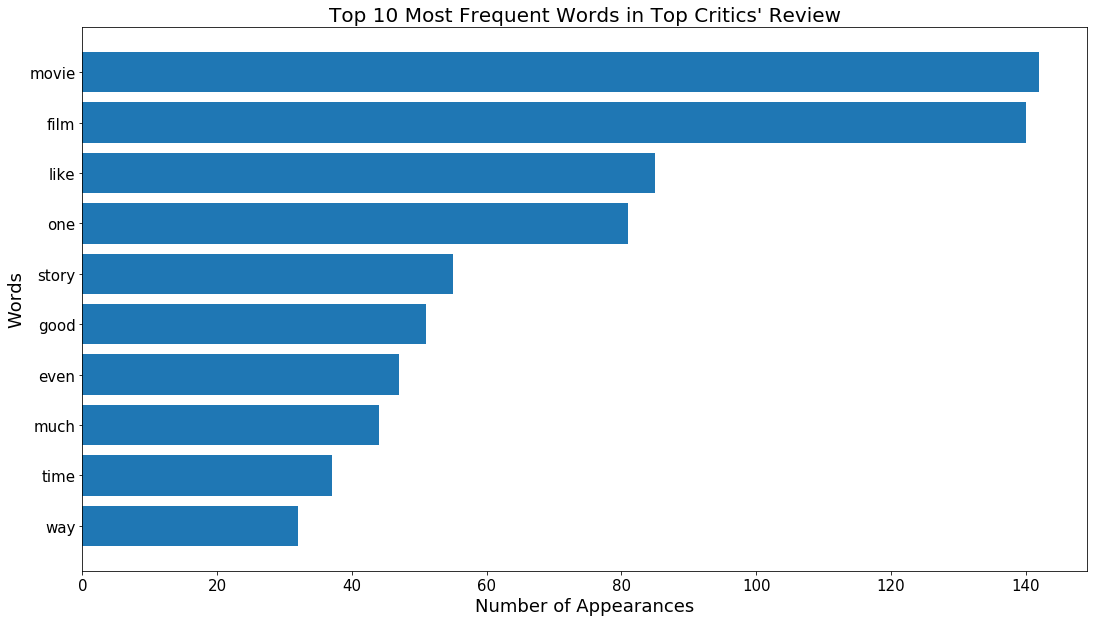

In [296]:
topcritic_top10 = df_topcritic.tail(10)

fig = plt.figure(figsize=(18,10))
plt.barh(topcritic_top10['word'], topcritic_top10['frequency'])
plt.title("Top 10 Most Frequent Words in Top Critics' Review",size=20)
plt.xlabel("Number of Appearances",size=18)
plt.ylabel("Words",size=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [311]:
df_nontop = df_final[df_final['top_critic']==0]
columns = ['review_content','top_critic','review_id']
df_nontop = df_nontop.drop(columns=columns)

words_nontop = np.asarray(list(df_nontop.columns))
df_critic = pd.DataFrame(words_nontop, columns=['word'])

df_nontop = df_nontop.T
df_nontop['sum'] = df_nontop.sum(axis=1)
frequency = np.asarray(list(df_nontop['sum']))

df_critic['frequency'] = frequency
df_critic = df_critic.sort_values('frequency', ascending=True)

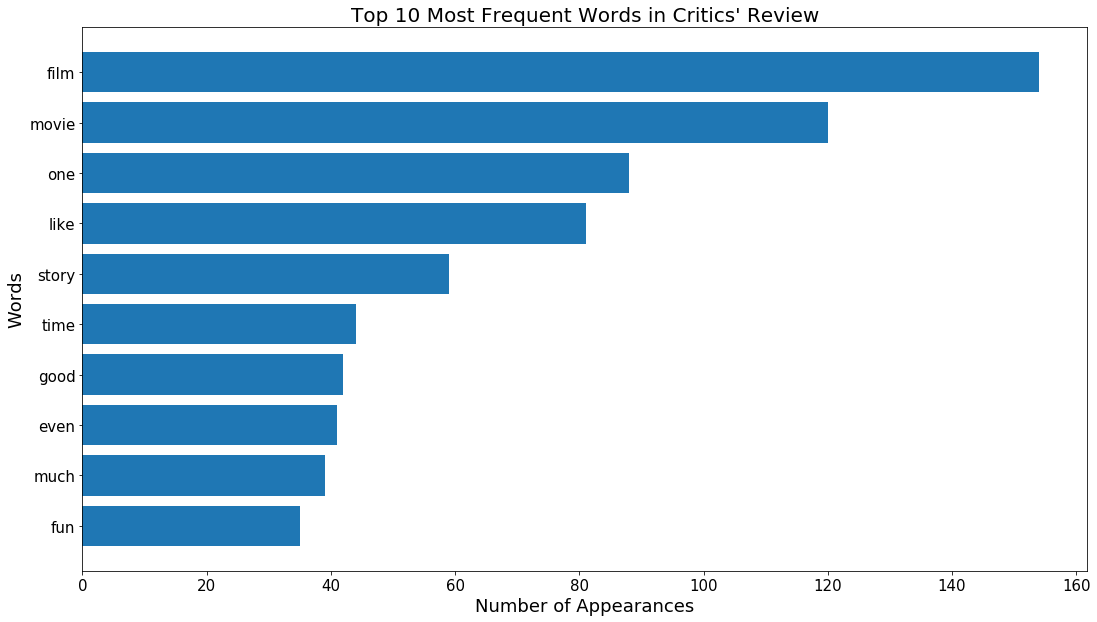

In [313]:
critic_top10 = df_critic.tail(10)

fig = plt.figure(figsize=(18,10))
plt.barh(critic_top10['word'], critic_top10['frequency'])
plt.title("Top 10 Most Frequent Words in Critics' Review",size=20)
plt.xlabel("Number of Appearances",size=18)
plt.ylabel("Words",size=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [321]:
topcritic_top10.sort_values('frequency',ascending=False)

,word,frequency
8652,movie,142
4962,film,140
7720,like,85
9206,one,81
12726,story,55
5677,good,51
4492,even,47
8672,much,44
13505,time,37
14596,way,32


In [322]:
critic_top10.sort_values('frequency',ascending=False)

,word,frequency
4962,film,154
8652,movie,120
9206,one,88
7720,like,81
12726,story,59
13505,time,44
5677,good,42
4492,even,41
8672,much,39
5363,fun,35
